## Abzooba Data Science Assignment
* Submitted by : Siddhesh Dosi

In [1]:
import pandas as pd
import numpy as  np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
train_data = pd.read_csv('Training Data.csv')
test_data = pd.read_csv('Test Data.csv')

In [3]:
print(f'Training data size : {train_data.shape} Test data size : {test_data.shape}')

Training data size : (180212, 11) Test data size : (119788, 10)


In [4]:
train_data.head()

,patient_id,Age,Gender,Prescription_period,Diabetes,Alcoholism,HyperTension,Smokes,Tuberculosis,Sms_Reminder,Adherence
0,1,19,M,7,0,0,0,0,0,0,No
1,2,24,F,59,0,0,0,0,0,0,No
2,3,4,F,43,0,0,0,0,0,0,No
3,4,38,M,66,0,0,0,0,0,1,No
4,5,46,F,98,0,0,0,0,0,1,No


In [5]:
test_data.head()

,patient_id,Age,Gender,Prescription_period,Diabetes,Alcoholism,HyperTension,Smokes,Tuberculosis,Sms_Reminder
0,1,5,M,28,0,0,0,0,0,1
1,2,62,F,9,1,0,1,0,0,0
2,3,4,F,73,0,0,0,0,0,1
3,4,33,M,117,0,0,0,0,0,0
4,5,38,M,8,0,0,0,0,0,1


In [6]:
## Check null value in training data
train_data.isna().sum()

patient_id             0
Age                    0
Gender                 0
Prescription_period    0
Diabetes               0
Alcoholism             0
HyperTension           0
Smokes                 0
Tuberculosis           0
Sms_Reminder           0
Adherence              0
dtype: int64

### Exploratory Data Analysis

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  


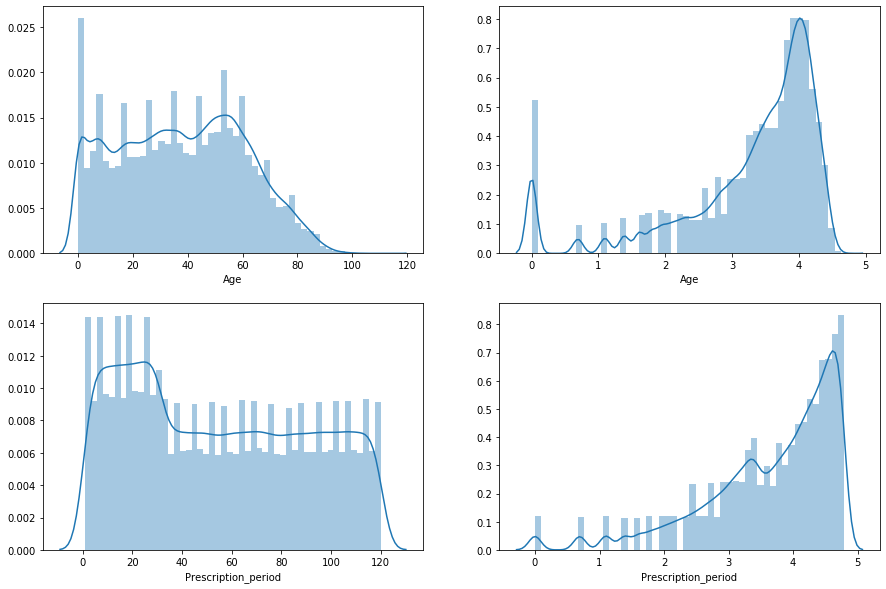

In [7]:
fig, axes = plt.subplots(ncols=2, nrows=2,figsize=(15, 10))

dist_features = ['Age','Prescription_period']
ax = axes.flat
i=0
for features in dist_features :
    sns.distplot(train_data[features], ax=ax[i],label= features + ' without log transformation')
    sns.distplot(np.log(train_data[features]).replace(-np.inf,0), ax=ax[i+1],label= features + ' with log transformation')
    i+=2
plt.show()



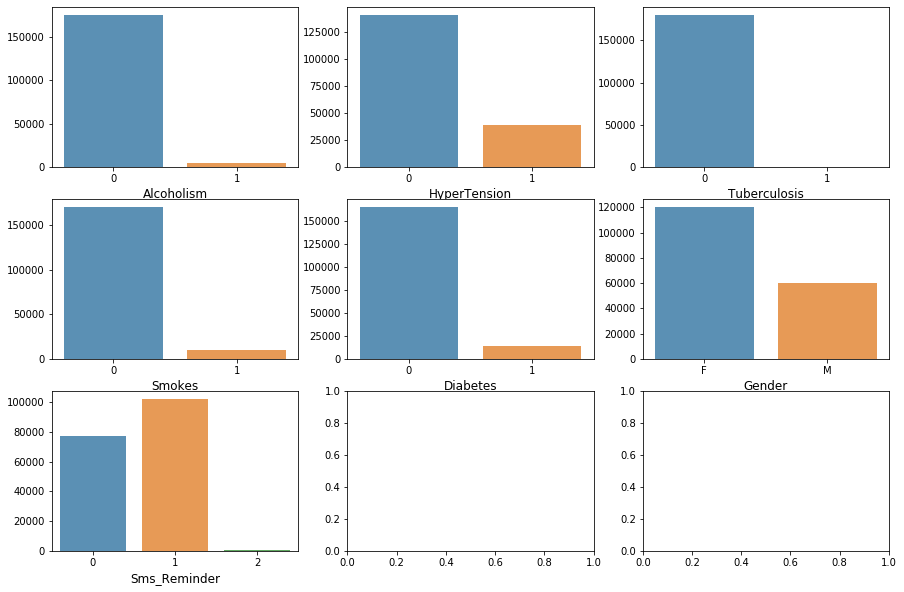

In [8]:
target = ['Adherence']
cat_features = list(set(train_data.columns)-set(dist_features+target+['patient_id']))

fig,axes = plt.subplots(ncols=3,nrows=3,figsize=(15, 10))
ax = axes.flat
i=0
for features in cat_features:
    bar_chart = train_data[features].value_counts()
    b = sns.barplot(x=bar_chart.index, y=bar_chart.values, alpha=0.8,ax=ax[i])
    ax[i].set_xlabel(features, fontsize=12)
    #ax[i].set_ylabel('Number of Occurrences', fontsize=12)
    i+=1
 
plt.show()


In [9]:
train_data.Adherence.value_counts()/train_data.shape[0]

No     0.698189
Yes    0.301811
Name: Adherence, dtype: float64

In [10]:
## Compare all category features with target 
for features in cat_features:
    res = pd.crosstab(train_data[features], train_data['Adherence'], normalize='index').mul(100)
    print('#'*40)
    print(res)

########################################
Adherence          No        Yes
Alcoholism                      
0           70.002675  29.997325
1           62.663417  37.336583
########################################
Adherence            No        Yes
HyperTension                      
0             68.339306  31.660694
1             75.172997  24.827003
########################################
Adherence            No        Yes
Tuberculosis                      
0             69.820872  30.179128
1             63.934426  36.065574
########################################
Adherence         No        Yes
Smokes                         
0          70.078307  29.921693
1          65.143038  34.856962
########################################
Adherence         No        Yes
Diabetes                       
0          69.403412  30.596588
1          74.694368  25.305632
########################################
Adherence         No        Yes
Gender                         
F          70.149787  

### Data Preprocess + Feature Engineer

In [11]:
def data_preprocess(df):
    
    #Create the age groups
    bins= [0,2,4,13,20,40,60,150]
    #['Infant','Toddler','Kid','Teen','Adult1', 'Adult2','Old']
    labels = [1,2,3,4,5,6,7]
    df['age_group'] = pd.cut(df['Age'],bins=bins,labels=labels)
    
    #Apply the log transformation on Prescription_period to decrease the variance 
    df['log_Prescription_period'] = np.log(df['Prescription_period']).replace(-np.inf,0)
    
    #Create new feature to add Diabetes + Tuberculosis + HyperTension
    df['Diabetes+TB+HyperTension'] = df['Diabetes'] + df['Tuberculosis'] + df['HyperTension']
    
    # Create new features to add Smokes + Alcoholism
    df['Smokes+Alocholism']=df['Smokes'] + df['Alcoholism']
    
    # Create new features  : total sms reminder  = sms reminder/day * Prescription_period
    df['tot_sms_reminder'] = df['Sms_Reminder'] * df ['Prescription_period']
    
    return df



### Prepare the training data set for model

In [12]:
train_df = data_preprocess(train_data)
test_df = data_preprocess(test_data)

train_df['Adherence'] = np.where(train_data['Adherence']=='Yes',1,0)

drop_col = ['patient_id','Age','Prescription_period']
continuous_feat = ['log_Prescription_period','tot_sms_reminder']
target_feat = ['Adherence']
category_feat = list(set(train_data.columns)-set(drop_col+target_feat)-set(continuous_feat))

train_df = pd.get_dummies(train_data,columns=category_feat)
test_df = pd.get_dummies(train_data,columns=category_feat)


X,y = train_df.drop(columns=drop_col+target_feat),train_df['Adherence']



In [13]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

### Apply all classification algorithm
* Check which classification is giving better result among all classification algorithm

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from xgboost import XGBClassifier
import xgboost as xgb

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score


#svc = SVC(kernel='sigmoid', gamma=1.0,probability=True)
svc = SVC(kernel='rbf', gamma=0.1,C=10,probability=True)
knc = KNeighborsClassifier(n_neighbors=49)
mnb = MultinomialNB(alpha=0.2)
dtc = DecisionTreeClassifier(min_samples_split=7, random_state=111)
lrc = LogisticRegression(solver='liblinear', penalty='l2')
rfc = RandomForestClassifier(n_estimators=31, random_state=111)
abc = AdaBoostClassifier(n_estimators=62, random_state=111)
bc = BaggingClassifier(n_estimators=9, random_state=111)
etc = ExtraTreesClassifier(n_estimators=9, random_state=111)
xg = XGBClassifier(n_estimators=200, max_depth=8,
                             max_features=10, n_jobs=32, bootstrap=True,
                             oob_score =True,
                             verbose=6,random_state = 111)

clfs = {'KN' : knc, 'NB': mnb, 'DT': dtc, 'LR': lrc, 'RF': rfc, 'AdaBoost': abc, 'BgC': bc, 'ETC': etc,'XGB':xg}
#clfs = {'SVC':svc}
#clfs = {'KN' : knc, 'NB': mnb, 'DT': dtc, 'LR': lrc, 'RF': rfc, 'AdaBoost': abc, 'BgC': bc, 'ETC': etc}

def train_classifier(clf, feature_train, labels_train):    
    clf.fit(feature_train, labels_train)
    
    
def predict_labels(clf, features):
    return (clf.predict(features))

def score(y_test,pred,average):
    f_score = f1_score(y_test,pred,average=average)
    precision=precision_score(y_test,pred,average=average)
    recall = recall_score(y_test,pred,average=average)
    return precision,recall,f_score

pred_scores = []
for k,v in clfs.items():
    train_classifier(v, X_train, y_train)
    pred = predict_labels(v,X_test)
    precision,recall,fscore =score(y_test,pred,average ='binary')
    res = {'Model':k,'Score':accuracy_score(y_test,pred),'Precision':precision,'Recall':recall,'F_Score':fscore}
    #pred_scores.append((k, [accuracy_score(y_test,pred)],[precision],[recall],[fscore]))
    pred_scores.append(res)
    
#df3 = pd.DataFrame.from_items(pred_scores,orient='index', columns=['Score','Precision,Recall,F_Score'])
df3 = pd.DataFrame(pred_scores)


In [19]:
df3.set_index('Model', inplace=True)
df3

,F_Score,Precision,Recall,Score
Model,,,,
KN,0.828336,0.782866,0.879413,0.889132
NB,0.538596,0.417306,0.759281,0.604306
DT,0.823382,0.781125,0.870473,0.886413
LR,0.727065,0.796588,0.668704,0.847294
RF,0.824853,0.779247,0.876129,0.886830
AdaBoost,0.834089,0.778586,0.898112,0.891324
BgC,0.824903,0.779265,0.876220,0.886857
ETC,0.821066,0.779380,0.867463,0.884998
XGB,0.832772,0.781690,0.890997,0.891158


#### XGB is giving better result than other model .

* Do fine tune the parameters
* Use cross validation to prevent from overfitting

In [22]:
from xgboost import XGBClassifier as xgb
from sklearn.model_selection import GridSearchCV
def xgb_param_selection(X, y, nfolds=5):
    n_estimators = [150,200]
    max_depth=[5,8,12]
    #max_features = [5,10,12]
    param_grid = {'n_estimators': n_estimators, 'max_depth' : max_depth}
    grid_search = GridSearchCV(xgb(), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search,grid_search.best_params_

xgb_model,xgb_best_prama = xgb_param_selection(X_test,y_test)
print('Best param of XGB : ',xgb_best_prama)

Best param of XGB :  {'max_depth': 5, 'n_estimators': 150}


#### Find all scores of the fine tune model

In [23]:
pred = predict_labels(xgb_model,X_test)
precision,recall,fscore =score(y_test,pred,average ='binary')
res = {'Model':k,'Score':accuracy_score(y_test,pred),'Precision':precision,'Recall':recall,'F_Score':fscore}
print(res)

{'Model': 'XGB', 'Score': 0.8922953139305829, 'Precision': 0.783217342612591, 'Recall': 0.8930949557602846, 'F_Score': 0.8345550630753495}


In [25]:
### Find the important features
feature_importances = pd.DataFrame(xgb_model.best_estimator_.feature_importances_,
                                   index =X_test.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)

feature_importances = feature_importances.reset_index()
feature_importances

,index,importance
0,log_Prescription_period,0.749624
1,age_group_7,0.024135
2,age_group_6,0.022043
3,Diabetes+TB+HyperTension_0,0.017440
4,Smokes+Alocholism_0,0.016158
5,Smokes_0,0.013404
6,Sms_Reminder_1,0.011994
7,Diabetes_0,0.011983
8,tot_sms_reminder,0.011129
9,Diabetes+TB+HyperTension_1,0.010549


In [30]:
from sklearn import metrics
from sklearn.metrics import roc_curve,confusion_matrix,auc
### Find optimal thresold
def Find_Optimal_Cutoff(target, predicted):
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.ix[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold'])

y_prob = xgb_model.predict_proba(X_test)[:, 1]
actual = pd.DataFrame(y_test)
actual.columns = ['actual']
pred = pd.DataFrame(y_prob)
pred.columns = ['pred']
bigdata = pd.concat([pred.reset_index(drop = True), actual.reset_index(drop = True)], axis=1, ignore_index=True)
bigdata.columns = ['pred', 'actual']

fpr, tpr, thresholds = metrics.roc_curve(bigdata['actual'].astype(int), bigdata['pred'])
threshold = Find_Optimal_Cutoff(bigdata['actual'].astype(int), bigdata['pred'])
print('Optimal Threshold : ',threshold)

bigdata['temp_cut_off'] = np.where(bigdata['pred'] >threshold[0], 1, 0)

cm1 = confusion_matrix(bigdata['actual'].astype(int), bigdata['temp_cut_off'])
print(cm1)

total1=sum(sum(cm1))
#####from confusion matrix calculate accuracy
accuracy1=(cm1[0,0]+cm1[1,1])/total1
print ('Accuracy : ', accuracy1)

sensitivity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1])
print('Sensitivity : ', sensitivity1 )

specificity1 = cm1[1,1]/(cm1[1,0]+cm1[1,1])
print('Specificity : ', specificity1)

roc_auc = auc(fpr, tpr)
print('AUC : ', roc_auc)



Optimal Threshold :  [0.5060890316963196]
[[22386  2694]
 [ 1189  9774]]
Accuracy :  0.8922675692922343
Sensitivity :  0.8925837320574163
Specificity :  0.8915442853233604
AUC :  0.9293709441108347


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


### Apply final model on test data



In [32]:
X_test = test_df[X_train.columns]

submission_df = pd.DataFrame()
y_prob = xgb_model.predict_proba(X_test)[:, 1]

submission_df['patient_id'] = test_df['patient_id']
submission_df['adherence'] = np.where(y_prob>threshold[0],'yes','no')
submission_df['probability score'] = y_prob

submission_df.to_csv('final_result.csv',index=False)